# FECHADO :)

# REGRESSAO LOGISTICA

In [30]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
import warnings



plt.rcParams.update({
        "text.usetex": True,              # If you want to use LaTeX fonts in text
        "font.family": "serif",           # IEEE uses Times New Roman-like fonts
        "font.size": 12,                   # General font size for IEEE format
        "axes.labelsize": 12,              # Axis labels font size
        "legend.fontsize": 11,             # Legend font size
        "xtick.labelsize": 11,             # X-axis tick labels font size
        "ytick.labelsize": 11,             # Y-axis tick labels font size
        "figure.figsize": (5, 5*0.8),
        "savefig.dpi": 900,               # DPI for high-quality PNG/JPEG
        "figure.dpi": 50,
    })

In [24]:
#df = pd.read_csv('08notsmote_FEAUTURES.csv')
df = pd.read_csv('10ma_FEAUTURES.csv')
df.head()

,pEffort,uaI,SleepInd,Sex_F,pEffort(MA6),SleepInd(MA6),uaI(MA6),Appetite(MA6),FatigInd
0,6.0,2.08,-5.00,1,4.678341,-4.713350,2.252252,5.297907,Optimal
1,1.0,2.00,-6.53,1,4.206534,-6.136979,1.997465,6.000013,Optimal
2,1.0,0.00,-4.00,0,3.712435,-3.576147,1.099577,4.884461,Optimal
3,5.0,2.69,-6.00,1,4.685066,-5.692758,2.201203,6.000000,Optimal
4,7.0,2.03,-5.00,1,6.853002,-5.523600,1.905526,6.028801,Optimal


In [25]:
X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

# standartizar os dados e separar treino de teste

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape

((511, 8), (128, 8))

## modelo base

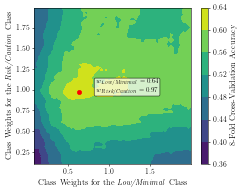

In [27]:
kf = []
weightsL = np.arange(0.1, 2, 0.03)  # Range for wLM #CHANGE TO 0.03 E RECONFIMAR PESOS
weightsRC = np.arange(0.1, 2, 0.03)  # Range for wRCM#CHANGE TO 0.03
grid_scores = np.zeros((len(weightsL), len(weightsRC)))

for i, wLM in enumerate(weightsL):
    for j, wRC in enumerate(weightsRC):
        class_weights = {"Low/Minimal": wLM, "Optimal": 1, "Risk/Caution": wRC}
        reglog = LogisticRegression(class_weight=class_weights, max_iter=1000)
        scores = cross_val_score(reglog, X_train, y_train, cv=8, scoring='accuracy')
        grid_scores[i, j] = scores.mean()
    #print(i / len(weightsL) * 100, "%")

X, Y = np.meshgrid(weightsL, weightsRC)
contour = plt.contourf(X, Y, grid_scores.T, cmap="viridis")  # Transpose for proper orientation
colorbar = plt.colorbar(contour)
colorbar.set_label("8-Fold Cross-Validation Accuracy", fontsize=12)

best_idx = np.unravel_index(np.argmax(grid_scores, axis=None), grid_scores.shape)
best_wLM = weightsL[best_idx[0]]
best_wRC = weightsRC[best_idx[1]]
best_score = grid_scores[best_idx]

plt.scatter(best_wLM, best_wRC, color="red", label="Best Solution", zorder=5)
txt = r'$w_{Low/Minimal} =' + f"{best_wLM:.2f}" + r"$" + "\n" + r'$w_{Risk/Caution} = ' f'{best_wRC:.2f}' + r'$'
plt.text(
    best_wLM + 0.2, best_wRC, txt, 
    color="black", fontsize=10, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2')
)

plt.xlabel(r'Class Weights for the \textit{Low/Minimal} Class')
plt.ylabel(r'Class Weights for the \textit{Risk/Caution} Class')
plt.tight_layout()
plt.savefig("assets/LOGR_class_weights.png", transparent=True)
plt.show()

In [28]:
warnings.filterwarnings("ignore")

# Define the model
model = LogisticRegression(max_iter=10000)

# Define the hyperparameter distribution
param_dist = {
    'penalty': ["l1", "l2", None],
    'C': stats.uniform(0.01, 300),  # Continuous range for C
    'solver': ['saga'],  # Continuous range for l1_ratio
    'class_weight': [
        {"Low/Minimal": .64, "Optimal": 1.0, "Risk/Caution": .97}, #RECONFIRMAR ISTO
        None,  # No class weights
    ],  # Class weights for balancing
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist, # Hyperparameter distribution
                                   n_iter=100, # iterations 
                                   cv=8, # cross-validation
                                   scoring='accuracy', # metric
                                   random_state=42) # seed
random_search.fit(X_train, y_train)

# Results
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Parameters: {'C': np.float64(2.1298915659152216), 'class_weight': {'Low/Minimal': 0.64, 'Optimal': 1.0, 'Risk/Caution': 0.97}, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.6264570932539683


In [31]:
best_model = random_search.best_estimator_
joblib.dump(best_model, 'model_reglog.pkl')

['model_reglog.pkl']

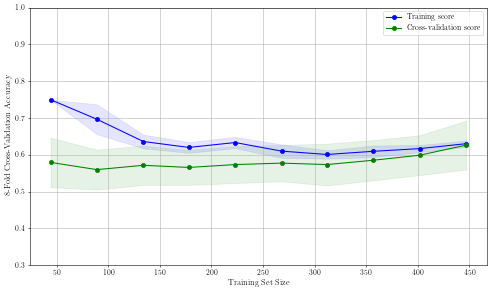

In [32]:


# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=8, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
#plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("8-Fold Cross-Validation Accuracy")
#plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.ylim(0.3, 1.0)
plt.grid()
plt.tight_layout()
plt.savefig("assets/LOGR_lercurve.png", transparent=True)
plt.show()


# medidas de avaliacao

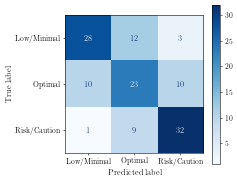

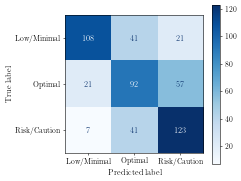

In [33]:
# Assuming X (features) and y (labels) are defined elsewhere in your code

# Split the data into train and test sets

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_model.classes_)
disp_test.plot(cmap="Blues")
#plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.savefig("assets/LOGR_confmatTest.png", transparent=True)
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_model.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_model.classes_)
disp_train.plot(cmap="Blues")
plt.tight_layout()
plt.savefig("assets/LOGR_confmatTrain.png", transparent=True)
plt.show()


In [34]:

y_pred_test = best_model.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.72      0.65      0.68        43
     Optimal       0.52      0.53      0.53        43
Risk/Caution       0.71      0.76      0.74        42

    accuracy                           0.65       128
   macro avg       0.65      0.65      0.65       128
weighted avg       0.65      0.65      0.65       128



In [35]:
y_pred_train = best_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.79      0.64      0.71       170
     Optimal       0.53      0.54      0.53       170
Risk/Caution       0.61      0.72      0.66       171

    accuracy                           0.63       511
   macro avg       0.64      0.63      0.63       511
weighted avg       0.64      0.63      0.63       511

